In [58]:
# Global imports
import biosteam as bst, thermosteam as tmo, biorefineries as bf, numpy as np, pandas as pd
from biorefineries import cellulosic
from biosteam import main_flowsheet as F, units

In [65]:
# Local imports
from atj_saf.atj_bst.etj_chemicals import *
from atj_saf.atj_bst.etj_settings import feed_parameters, dehyd_data, olig_data, prod_selectivity, hydgn_data, price_data, h2_recovery, gal_to_m3
from atj_saf.atj_bst.etj_utils import calculate_ethanol_flow
from atj_saf.atj_bst.atj_bst_units import AdiabaticReactor, IsothermalReactor, EthanolStorageTank, HydrocarbonProductTank, HydrogenStorageTank, CatalystMixer
from atj_saf.atj_bst.atj_bst_tea_saf import ConventionalEthanolTEA
from cellulosic_tea_etj import create_cellulosic_ethanol_tea

In [3]:
bst.F.set_flowsheet('etj') # F is the main flowsheet


In [4]:
atj_chems = create_chemicals()
bst.settings.set_thermo(atj_chems) # Setting thermodynamic property pacakge for the chemicals


In [5]:
bst.settings.CEPCI = 800.8 # For the year 2023 from https://personalpages.manchester.ac.uk/staff/tom.rodgers/Interactive_graphs/CEPCI.html?reactors/CEPCI/index.html
bst.settings.electricity_price = price_data['electricity']

In [6]:
etoh_flow = calculate_ethanol_flow(9) 

In [7]:
# Bioethanol feed
etoh_in = bst.Stream(
    'Ethanol_In',
    Ethanol = etoh_flow,
    Water =  etoh_flow*((1-feed_parameters['purity'])/(feed_parameters['purity'])),
    units = 'kg/hr',
    T = feed_parameters['temperature'],
    P = feed_parameters['pressure'],
    phase = feed_parameters['phase'])




In [8]:
 # Reactions

#1) Gas phase dehydration of ethanol to ethylene 
dehydration_rxn = bst.Reaction('Ethanol,g -> Water,g + Ethylene,g', reactant = 'Ethanol', 
                            X = dehyd_data['conv'], phases = 'lg',  basis = 'mol')


#2) Ethylene oligomerization to olefins in gas and liquid phase
oligomerization_rxn = bst.ParallelReaction([
# Reaction definition                                     # Reactant                    # Conversion
bst.Reaction('2Ethylene,g -> Butene,g',            reactant = 'Ethylene',     X = olig_data['conv']*prod_selectivity['C4H8'],    basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('1.5Ethylene,g -> Hex-1-ene,g',       reactant = 'Ethylene',     X = olig_data['conv']*prod_selectivity['C6H12'],   basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('5Ethylene,g -> Dec-1-ene,l',         reactant = 'Ethylene',     X = olig_data['conv']*prod_selectivity['C10H20'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('9Ethylene,g -> Octadec-1-ene,l',     reactant = 'Ethylene',     X = olig_data['conv']*prod_selectivity['C18H36'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True)])


hydrogenation_rxn = bst.ParallelReaction([
# Reaction definition                                           # Reactant                    # Conversion
bst.Reaction('Butene,g + Hydrogen,g -> Butane,g',               reactant = 'Butene',          X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Butene,l + Hydrogen,g -> Butane,l',               reactant = 'Butene',          X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Hex-1-ene,g + Hydrogen,g -> Hexane,g',            reactant = 'Hex-1-ene',       X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Hex-1-ene,l + Hydrogen,g -> Hexane,l',            reactant = 'Hex-1-ene',       X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Dec-1-ene,l + Hydrogen,g -> Decane,l',            reactant = 'Dec-1-ene',       X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Dec-1-ene,g + Hydrogen,g -> Decane,g',            reactant = 'Dec-1-ene',       X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Octadec-1-ene,l + Hydrogen,g -> Octadecane,l',    reactant = 'Octadec-1-ene',   X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True),
bst.Reaction('Octadec-1-ene,g + Hydrogen,g -> Octadecane,g',    reactant = 'Octadec-1-ene',   X = hydgn_data['conv'],  basis = 'mol',  phases = 'lg',  correct_atomic_balance = True)])


In [9]:
# Recycle streams
dehyd_recycle = bst.MultiStream('dehyd_recycle', phases = ('g','l'))         # Unreacted ethanol
ethylene_recycle = bst.MultiStream('ethylene_recycle', phases = ('g','l'))   # Unreacted ethylene   
h2_recycle= bst.Stream(ID = 'h2_recycle', P = 3e6, phase = 'g')              # Excess hydrogen


In [10]:
# Area naming convention
# 100: Feed Storage [Ethanol and Hydrogen]
# 200: Catalytic Upgrading
# 300: Product Fractionation
# 400: Boiler Turbogenerator
# 500: Product Storage [Hydrocarbon fuels]
# 600: Wastewater Treatment

In [11]:
etoh_storage = EthanolStorageTank('T101', ins = etoh_in)
etoh_storage.simulate()


# Area 200: Catalytic Upgrading 
pump_1 = bst.Pump('P201', ins = etoh_storage.outs[0], P = 1373000)    
pump_1.simulate()

furnace_1 = bst.HXutility('H201', ins = pump_1.outs[0], T = 500, rigorous = True)
furnace_1.simulate()

mixer_1 = bst.Mixer('M201', ins = (furnace_1.outs[0], dehyd_recycle), rigorous = True)
mixer_1.simulate()

furnace_2 =  bst.HXutility('H202', ins = mixer_1.outs[0], T = 481 + 273.15, rigorous = True)
furnace_2.simulate()

dehyd_1 = AdiabaticReactor('R201', ins = furnace_2.outs[0],
                        conversion = dehyd_data['conv'],
                        temperature = dehyd_data['temp'],
                        pressure = dehyd_data['pressure'],
                        WHSV = dehyd_data['whsv'],
                        vessel_type = 'Vertical',
                        vessel_material = 'Stainless steel 316',
                        catalyst_price=price_data['dehydration_catalyst'],
                        catalyst_lifetime = dehyd_data['catalyst_lifetime'],
                        reaction = dehydration_rxn)
dehyd_1.simulate()


# Dehydration catalyst replacement 
syndol_wt = dehyd_1.get_design_result('Catalyst Weight', 'kg')
syndol_req = syndol_wt/dehyd_data['catalyst_lifetime']
syndol_replacement = bst.Stream('Dehyd_cat_replacement', Syndol = syndol_req, phase = 's', units = 'kg/yr' )

splitter_1 = bst.Splitter('S201', ins = dehyd_1.outs[0], outs = ('flash_in', dehyd_recycle), split = 0.3)
splitter_1.simulate()

flash_1 = bst.Flash('T201', ins = splitter_1.outs[0], outs = ('ETHYLENE_WATER', 'WW_1'), T= 420,  P = 1.063e6)
flash_1.simulate()


comp_1 = bst.IsentropicCompressor('K201', ins = flash_1.outs[0], P = 2e6, vle = True, eta = 0.72, driver_efficiency = 1)
comp_1.simulate()   

distillation_1 = bst.BinaryDistillation('D201', ins = comp_1.outs[0], 
                                            outs = ('ethylene_water', 'WW'),
                                LHK = ('Ethylene', 'Water'), 
                                P = 2e+06,
                                y_top = 0.999, x_bot = 0.001, k = 2,
                                is_divided = False)
distillation_1.simulate()

comp_2 = bst.IsentropicCompressor('K202', ins = distillation_1.outs[0], P = olig_data['pressure'], vle = True, eta = 0.72, driver_efficiency = 1)
comp_2.simulate()

distillation_2 = bst.BinaryDistillation('D202', ins = comp_2.outs[0],
                                LHK = ('Ethylene', 'Ethanol'),
                                P = 3.5e+06,
                                y_top = 0.9999, x_bot = 0.0001, k = 2,
                                is_divided = False)
distillation_2.simulate()


cooler_3 = bst.HXutility('H203', ins = distillation_2.outs[0], T = 393.15, rigorous = True)
cooler_3.simulate()

mixer_2 = bst.Mixer(ID = 'M202', ins = (cooler_3.outs[0],ethylene_recycle), rigorous = True)
mixer_2.simulate()

olig_1 = IsothermalReactor('R202', ins = mixer_2.outs[0],
                            conversion = olig_data['conv'],
                            temperature = olig_data['temp'],
                            pressure = olig_data['pressure'],
                            WHSV = olig_data['whsv'],
                            catalyst_price = price_data['oligomerization_catalyst'],
                        reaction = oligomerization_rxn)
olig_1.simulate()

# Oligomerization catalyst replacement 
ni_si_al_wt = olig_1.get_design_result('Catalyst Weight', 'kg')
ni_si_al_req = ni_si_al_wt/olig_data['catalyst_lifetime']
ni_si_al_replacement = bst.Stream('Olig_cat_replacement', Nickel_SiAl = ni_si_al_req, phase = 's', units = 'kg/yr' )

splitter_2 = bst.Splitter('S202', ins = olig_1.outs[0], outs = (ethylene_recycle,'oligs'),  split = {'Ethylene':1.0})
splitter_2.simulate()

h2_in = bst.Stream(ID = 'Hydrogen_In',  P = 3e6, phase= 'g')


# 3:1 excess hydrogen to oligomers molar ratio, with 100% molar conversion 2 x moles oligomer H2 is left, and 85 mol% is recovered, meaning
# fresh h2 in needs to be enough to make up for reacted H2 (1 X moles oligomer) and hydrogen lost in PSA (0.15 * 2 X moles oligomer) 

h2_storage = HydrogenStorageTank('T102',ins = h2_in)                                    # Also a part of Area 100
@h2_storage.add_specification(run = True)
def h2_flow():
    h2_flow = 3*((olig_1.outs[0].imol['Butene'] + olig_1.outs[0].imol['Hex-1-ene']
                    + olig_1.outs[0].imol['Dec-1-ene'] + olig_1.outs[0].imol['Octadec-1-ene']))
    
    h2_storage.ins[0].imol['Hydrogen'] = h2_flow - h2_recycle.imol['Hydrogen']
h2_storage.simulate()


mixer_4 = bst.Mixer('M203', ins = (h2_storage.outs[0], splitter_2.outs[1], h2_recycle), rigorous = True)
mixer_4.simulate()


furnace_3 = bst.HXutility('H204', mixer_4.outs[0], T = 350 +273.15, rigorous = True)
furnace_3.simulate()


hydgn_1 = AdiabaticReactor('R203', ins = furnace_3.outs[0],
                        conversion = hydgn_data['conv'],
                        temperature = hydgn_data['temp'],
                        pressure = hydgn_data['pressure'],
                        WHSV = hydgn_data['whsv'],
                        catalyst_price = price_data['hydrogenation_catalyst'],
                        reaction = hydrogenation_rxn)
hydgn_1.simulate()


# Hydrogenation catalyst replacement 
co_mo_wt = hydgn_1.get_design_result('Catalyst Weight', 'kg')
co_mo_req = co_mo_wt/hydgn_data['catalyst_lifetime']
co_mo_replacement = bst.Stream('Hydgn_cat_replacement', CobaltMolybdenum = co_mo_req, phase = 's', units = 'kg/yr' )

cooler_5 = bst.HXutility('H205', ins = hydgn_1.outs[0], T = 250, rigorous = True) 
cooler_5.simulate()


flash_2 = bst.Flash('T202', ins = cooler_5-0, T = 250, P = 5e5)
flash_2.simulate()

psa_splitter = bst.Splitter('S203', ins = flash_2-0, outs = (h2_recycle,'BT_feed'),  split = {'Hydrogen':h2_recovery})



c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarning: the purchase cost item, 'Total Cost', has no defined bare-module factor in the 'EthanolStorageTank.F_BM' dictionary; bare-module factor now has a default value of 1
  warn(f"the purchase cost item, '{name}', has "
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\bubble_point.py:128: RuntimeWarning: Ethylene has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: T201> Vertical vessel weight (314.6 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: T201> Vertical vessel length (5.5 ft) is out of bounds (1

In [12]:

# Area 300: Product Fractionation
distillation_3 = bst.BinaryDistillation('D301', ins = flash_2.outs[1],
                                outs = ('distillate', 'bottoms'),
                                LHK = ('Hexane', 'Decane'),
                                y_top = 0.99, x_bot = 0.01, k = 2,
                                is_divided = True)
distillation_3.simulate()

distillation_4 = bst.BinaryDistillation('D302', ins = distillation_3.outs[1],
                                outs = ('distillate_1', 'bottoms_1'),
                                LHK = ('Decane', 'Octadecane'),
                                y_top = 0.99, x_bot = 0.01, k = 2,
                                is_divided = True)
distillation_4.simulate()

cooler_6 = bst.HXutility('H301', ins = distillation_3.outs[0]
                            ,V = 0, rigorous = True)
cooler_6.simulate()


cooler_7 = bst.HXutility('H302', ins = distillation_4.outs[0],T = 15+273.15, rigorous = True)
cooler_7.simulate()
cooler_7.outs[0].phase = 'l'   # Just setting it as liquid, because rigorous = True gives both l and g phases. 
                               # Actual phase is liquid only so asserting phase like this is fine

cooler_8 = bst.HXutility('H303', ins = distillation_4.outs[1],T = 15+273.15, rigorous = True)
cooler_8.simulate()
cooler_8.outs[0].phase = 'l'

# Area 500: Product Storage

rn_storage = HydrocarbonProductTank('T501', ins = cooler_6.outs[0], outs = 'RN')
rn_storage.simulate()

saf_storage = HydrocarbonProductTank('T502', ins = cooler_7.outs[0], outs = 'SAF')
saf_storage.simulate()


rd_storage = HydrocarbonProductTank('T503', ins = cooler_8.outs[0], outs = 'RD')
rd_storage.simulate()


# Area 500: Wastewater Treatment

WW_mixer = bst.Mixer('M601', ins = (flash_1-1, distillation_1-1, distillation_2-1), rigorous = True)
WW_mixer.simulate()

WW_cooler = bst.HXutility('H602', ins = WW_mixer.outs[0], V = 0, rigorous = True)
WW_cooler.simulate()

WWT = bst.create_conventional_wastewater_treatment_system(ins=WW_cooler.outs[0])


# Area 400: Boiler Turbogenerator

BT = bst.facilities.BoilerTurbogenerator(fuel_price = price_data['NG'])   # Boiler turbogenerator
BT.ins[1] = F.BT_feed


catalyst_replacement_unit = CatalystMixer('Catalyst_Mixer', ins = (syndol_replacement, ni_si_al_replacement, co_mo_replacement))
catalyst_replacement_unit.simulate()


c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\dew_point.py:129: RuntimeWarning: Hydrogen has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <RefluxDrum: reflux_drum> Vertical vessel weight (255.2 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <RefluxDrum: reflux_drum> Vertical vessel length (4.5 ft) is out of bounds (12 to 40 ft) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarning: the purchase cost item, 'Total Cost', has no defined bare-module factor in the 'HydrocarbonProductTank.F_BM' diction

In [13]:
atj_sys = bst.System('atj_sys', path = (etoh_storage, pump_1, furnace_1, mixer_1, furnace_2, dehyd_1, splitter_1, flash_1, comp_1, 
                                        distillation_1, comp_2, distillation_2, cooler_3, mixer_2,
                                        olig_1, splitter_2, h2_storage, mixer_4, furnace_3, hydgn_1, cooler_5, 
                                        flash_2, psa_splitter, distillation_3, distillation_4, cooler_6, cooler_7, cooler_8,
                                        rn_storage, saf_storage, rd_storage, WW_mixer, WW_cooler, catalyst_replacement_unit), 
                                        facilities = [WWT, BT],
                                        recycle = (dehyd_recycle, ethylene_recycle, h2_recycle))
atj_sys.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: T201> Vertical vessel weight (860.9 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: T201> Vertical vessel length (6.5 ft) is out of bounds (12 to 40 ft) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:1241: CostWarning: <IsentropicCompressor: K202> power (122.4 hp) is out of bounds (200 to 3e+04 hp) for cost correlation
  self._cost(**cost_kwargs) if cost_kwargs else self._cost()
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <RefluxDrum: reflux_drum> Vertical vessel weight (751.3 lb) is out of bounds (4200 to 1e+06 lb

In [14]:
atj_sys.show()

System: atj_sys
Highest convergence error among components in recycle
streams {S201-1, S202-0, S203-0} after 4 loops:
- flow rate   2.26e-03 kmol/hr (0.00072%)
- temperature 7.40e-04 K (0.00012%)
ins...
[0] Ethanol_In  
    phase: 'l', T: 293.15 K, P: 101325 Pa
    flow (kmol/hr): Water    2.09
                    Ethanol  162
[1] Hydrogen_In  
    phase: 'g', T: 298.15 K, P: 3e+06 Pa
    flow (kmol/hr): Hydrogen  58.4
[2] air_lagoon  
    phase: 'g', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): N2  0.439
                    O2  0.108
[3] caustic  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  0.944
                    NaOH   0.425
[4] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[5] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  35.7
[6] -  
    phase: 'g', T: 288.71 K, P: 101560 Pa
    flow (kmol/hr): CH4  60.2
[7] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[8] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa


In [15]:
atj_sys.diagram(format = 'png', file = 'atj_s')

In [16]:
# Mass balance error check
feed_flow = 0
for i in range(13):
    feed_flow += (atj_sys.feeds[i].F_mass)

prod_flow = 0
for i in range(12):
    prod_flow += (atj_sys.products[i].F_mass)

mass_bal_error = abs(feed_flow - prod_flow)

percentage_diff = ((mass_bal_error/feed_flow)*100)

print(f'The feed flow rate is {round(feed_flow,2)} kg/hr and the product flow rate is {round(prod_flow,2)} kg/hr')
print(f'Difference is {mass_bal_error}')
print(f'Percentage difference is {round((percentage_diff),3)} %')

The feed flow rate is 64094.19 kg/hr and the product flow rate is 64084.9 kg/hr
Difference is 9.285135304882715
Percentage difference is 0.014 %


### Estimation of labor costs
In accordance with methodology in Sieder book

In [17]:

operators_per_section = 1  # operators per section from Seider recommendation
num_process_sections = 5  # number of proces sections from Seider recommendation [5 areas - storage, upgrading, separation, wwt, bt)
num_operators_per_shift = operators_per_section * num_process_sections * 1  # multiplied by 2 for large continuous flow process (e.g., 1000 ton/day product). from Seider pg 505
num_shifts = 5  # number of shifts
pay_rate = 40  # $/hr
DWandB = num_operators_per_shift * num_shifts * 2080 * pay_rate  # direct wages and benefits. DWandB [$/year] = (operators/shift)*(5 shifts)*(40 hr/week)*(operating days/year-operator)*($/hr)
Dsalaries_benefits = 0.15 * DWandB  # direct salaries and benefits from Seider
O_supplies = 0.06 * DWandB  # Operating supplies and services from Seider
technical_assistance = 5 * 75000  # $/year. Technical assistance to manufacturing. assume 5 workers at $75000/year
control_lab = 5 * 80000  # $/year. Control laboratory. assume 5 workers at $80000/year
labor = DWandB + Dsalaries_benefits + O_supplies + technical_assistance + control_lab 

    

### Prices data 

In [18]:
F.Ethanol_In.price = price_data['ethanol']            
F.Hydrogen_In.price = price_data['hydrogen']
F.RN.price = price_data['renewable_naphtha']
saf_stream = F.SAF
F.RD.price = price_data['renewable_diesel']
F.Dehyd_cat_replacement.price = price_data['dehydration_catalyst']
F.Olig_cat_replacement.price = price_data['oligomerization_catalyst']
F.Hydgn_cat_replacement.price = price_data['hydrogenation_catalyst']


In [19]:
final_tea = create_cellulosic_ethanol_tea(atj_sys)


In [20]:
final_tea.labor_cost = labor

In [21]:
print(f'The Total Capital Investement for ETJ biorefinery is {round(final_tea.TCI/1e6,2)} MM USD')

The Total Capital Investement for ETJ biorefinery is 95.61 MM USD


In [ ]:
mjsp = round(((final_tea.solve_price(F.SAF)*F.SAF.rho)/264.172),2)


8.34

In [70]:
print(f'The MSP for ETJ-derived SAF is  {mjsp} USD/gal')

The MSP for ETJ-derived SAF is  8.34 USD/gal


In [23]:
print('ETJ system installed equipment cost is', round(atj_sys.installed_equipment_cost / 1e6, 2), 'MM USD')
print('ETJ system purchase equipment cost is', round(atj_sys.purchase_cost / 1e6, 2), 'MM USD')


ETJ system installed equipment cost is 54.95 MM USD
ETJ system purchase equipment cost is 41.1 MM USD


In [24]:
print(f'The Wastewater system cost is {round(F.WWTC.installed_cost/1e6,2)} MM USD')

The Wastewater system cost is 3.9 MM USD


# Cost Breakdown plot

In [41]:
# Defining process sections
catalytic_upgrading = [pump_1, furnace_1, mixer_1, furnace_2, dehyd_1, splitter_1, flash_1, comp_1, 
                                        distillation_1, comp_2, distillation_2, cooler_3, mixer_2,
                                        olig_1, splitter_2, mixer_4, furnace_3, hydgn_1, cooler_5, 
                                        flash_2, psa_splitter]


product_fractionation = [distillation_3, distillation_4, cooler_6, cooler_7, cooler_8]

storage = [etoh_storage, h2_storage, saf_storage, rn_storage, rd_storage]

BT = [BT]

WWT = [WWT]

In [72]:
# Defining the different costs for each section

# CAPEX breakdown
cat_upgrading_installed_cost = sum(u.installed_cost for u in catalytic_upgrading)
prod_frac_installed_cost = sum(u.installed_cost for u in product_fractionation)
storage_installed_cost = sum(u.installed_cost for u in storage)
BT_installed_cost = F.BT.installed_cost
WWT_installed_cost  = F.WWTC.installed_cost
installed_costs_arr = np.array([cat_upgrading_installed_cost, prod_frac_installed_cost, storage_installed_cost, 
                            BT_installed_cost, WWT_installed_cost, 0, 0, 0])

# Catalyst replacement cost
catalyst_replacement = (F.Dehyd_cat_replacement.F_mass * F.Dehyd_cat_replacement.price +
                        F.Olig_cat_replacement.F_mass * F.Olig_cat_replacement.price + 
                        F.Hydgn_cat_replacement.F_mass * F.Hydgn_cat_replacement.price) * final_tea.operating_hours
catalyst_replacement_arr = np.zeros(8)
catalyst_replacement_arr[0] = catalyst_replacement

# Electricity 
cat_upgrading_electricity = sum(u.power_utility.consumption for u in catalytic_upgrading)*price_data['electricity']*final_tea.operating_hours
prod_frac_electricity = sum(u.power_utility.consumption for u in product_fractionation)*price_data['electricity']*final_tea.operating_hours
storage_electricity = sum(u.power_utility.consumption for u in storage)*price_data['electricity']*final_tea.operating_hours
BT_electricity = F.BT.power_utility.consumption*price_data['electricity']*final_tea.operating_hours
WWT_electricity = F.WWTC.power_utility.consumption*price_data['electricity']*final_tea.operating_hours
electricity_arr = np.array([cat_upgrading_electricity, prod_frac_electricity, storage_electricity, BT_electricity, 
                            WWT_electricity, 0, 0, 0])


# Utility cost
cat_upgrading_utility_cost = sum(u.utility_cost if u.utility_cost is not None else 0 for u in catalytic_upgrading)*final_tea.operating_hours
prod_frac_utility_cost = sum(u.utility_cost if u.utility_cost is not None else 0 for u in product_fractionation)*final_tea.operating_hours
storage_utility_cost = sum(u.utility_cost if u.utility_cost is not None else 0 for u in storage)*final_tea.operating_hours
BT_utility_cost = F.BT.utility_cost*final_tea.operating_hours
WWT_utility_cost = F.WWTC.utility_cost*final_tea.operating_hours
utility_arr = np.array([cat_upgrading_utility_cost, prod_frac_utility_cost, storage_utility_cost, BT_utility_cost, 
                            WWT_utility_cost, 0, 0, 0])

# Fixed Costs [USD/yr]
cat_upgrading_fixed_costs = final_tea.FOC*(1/5) 
prod_frac_fixed_costs = final_tea.FOC*(1/5) 
storage_fixed_costs = final_tea.FOC*(1/5) 
BT_fixed_costs = final_tea.FOC*(1/5) 
WWT_fixed_costs = final_tea.FOC*(1/5) 
fixed_costs_arr = np.array([cat_upgrading_fixed_costs, prod_frac_fixed_costs, storage_fixed_costs, BT_fixed_costs, WWT_fixed_costs, 0, 0, 0])

#Hydrogen [USD/yr]
cat_upgrading_h2 = F.Hydrogen_In.F_mass * F.Hydrogen_In.price * final_tea.operating_hours
h2_arr = np.zeros(8)
h2_arr[0] = cat_upgrading_h2

#Bioethanol feed cost [USD/yr]
etoh_cost = F.Ethanol_In.F_mass * F.Ethanol_In.price * final_tea.operating_hours
etoh_cost_arr = np.zeros(8)
etoh_cost_arr[7] = etoh_cost 

# Co product costs
rn_sales = F.RN.F_mass * F.RN.price * final_tea.operating_hours
rd_sales = F.RD.F_mass * F.RD.price * final_tea.operating_hours
co_product_arr = np.zeros(8)
co_product_arr[5] = -rn_sales
co_product_arr[6] = -rd_sales



In [73]:
# Costs in $/gal basis
saf_annual_prod = (F.SAF.F_vol*final_tea.operating_days*24)/gal_to_m3
electricity_per_gal = electricity_arr/saf_annual_prod
utility_per_gal = utility_arr/saf_annual_prod
fixed_cost_per_gal = fixed_costs_arr/saf_annual_prod
h2_cost_per_gal = h2_arr/saf_annual_prod
etoh_cost_per_gal = etoh_cost_arr/saf_annual_prod
cat_replacement_per_gal = catalyst_replacement_arr/saf_annual_prod
co_product_per_gal = co_product_arr/saf_annual_prod

In [74]:
# Installed costs in $/gal basis
everything_else = sum(cat_replacement_per_gal)+ sum(utility_per_gal)+ sum(electricity_per_gal)+ sum(fixed_cost_per_gal)+sum(h2_cost_per_gal)+ sum(etoh_cost_per_gal)+sum(co_product_per_gal)
installed_costs_per_gal = (installed_costs_arr/atj_sys.installed_cost)*(mjsp-everything_else)

In [83]:
import numpy as np

# Legend categories (costs)
legend_categories = [
    'Installed costs', 
    'Catalyst replacement', 
    'Utilities excl. electricity', 
    'Process electricity', 
    'Fixed costs', 
    'Hydrogen', 
    'Ethanol', 
    'Co-product'
]

# Bar categories (processes)
bar_categories = [
    'Catalytic upgrading', 
    'Product fractionation', 
    'Storage', 
    'Boiler Turbogenerator',
    'Wastewater Treatment',
    'Renewable naphtha', 
    'Renewable diesel', 
    'Bioethanol'
]

# Example arrays for each cost (fill in your real values)
installed_costs        = installed_costs_per_gal
catalyst_replacement   = cat_replacement_per_gal
utilities_excl_elec    = utility_per_gal
process_electricity    = electricity_per_gal
fixed_costs            = fixed_cost_per_gal
hydrogen               = h2_cost_per_gal
ethanol                = etoh_cost_per_gal
co_product             = co_product_per_gal

# Stack all cost arrays into a single 2D array
costs = np.vstack([
    installed_costs, 
    catalyst_replacement, 
    utilities_excl_elec, 
    process_electricity, 
    fixed_costs, 
    hydrogen, 
    ethanol, 
    co_product
])

In [85]:
cost_breakdown_df = pd.DataFrame(costs.T, columns=legend_categories, index=bar_categories)


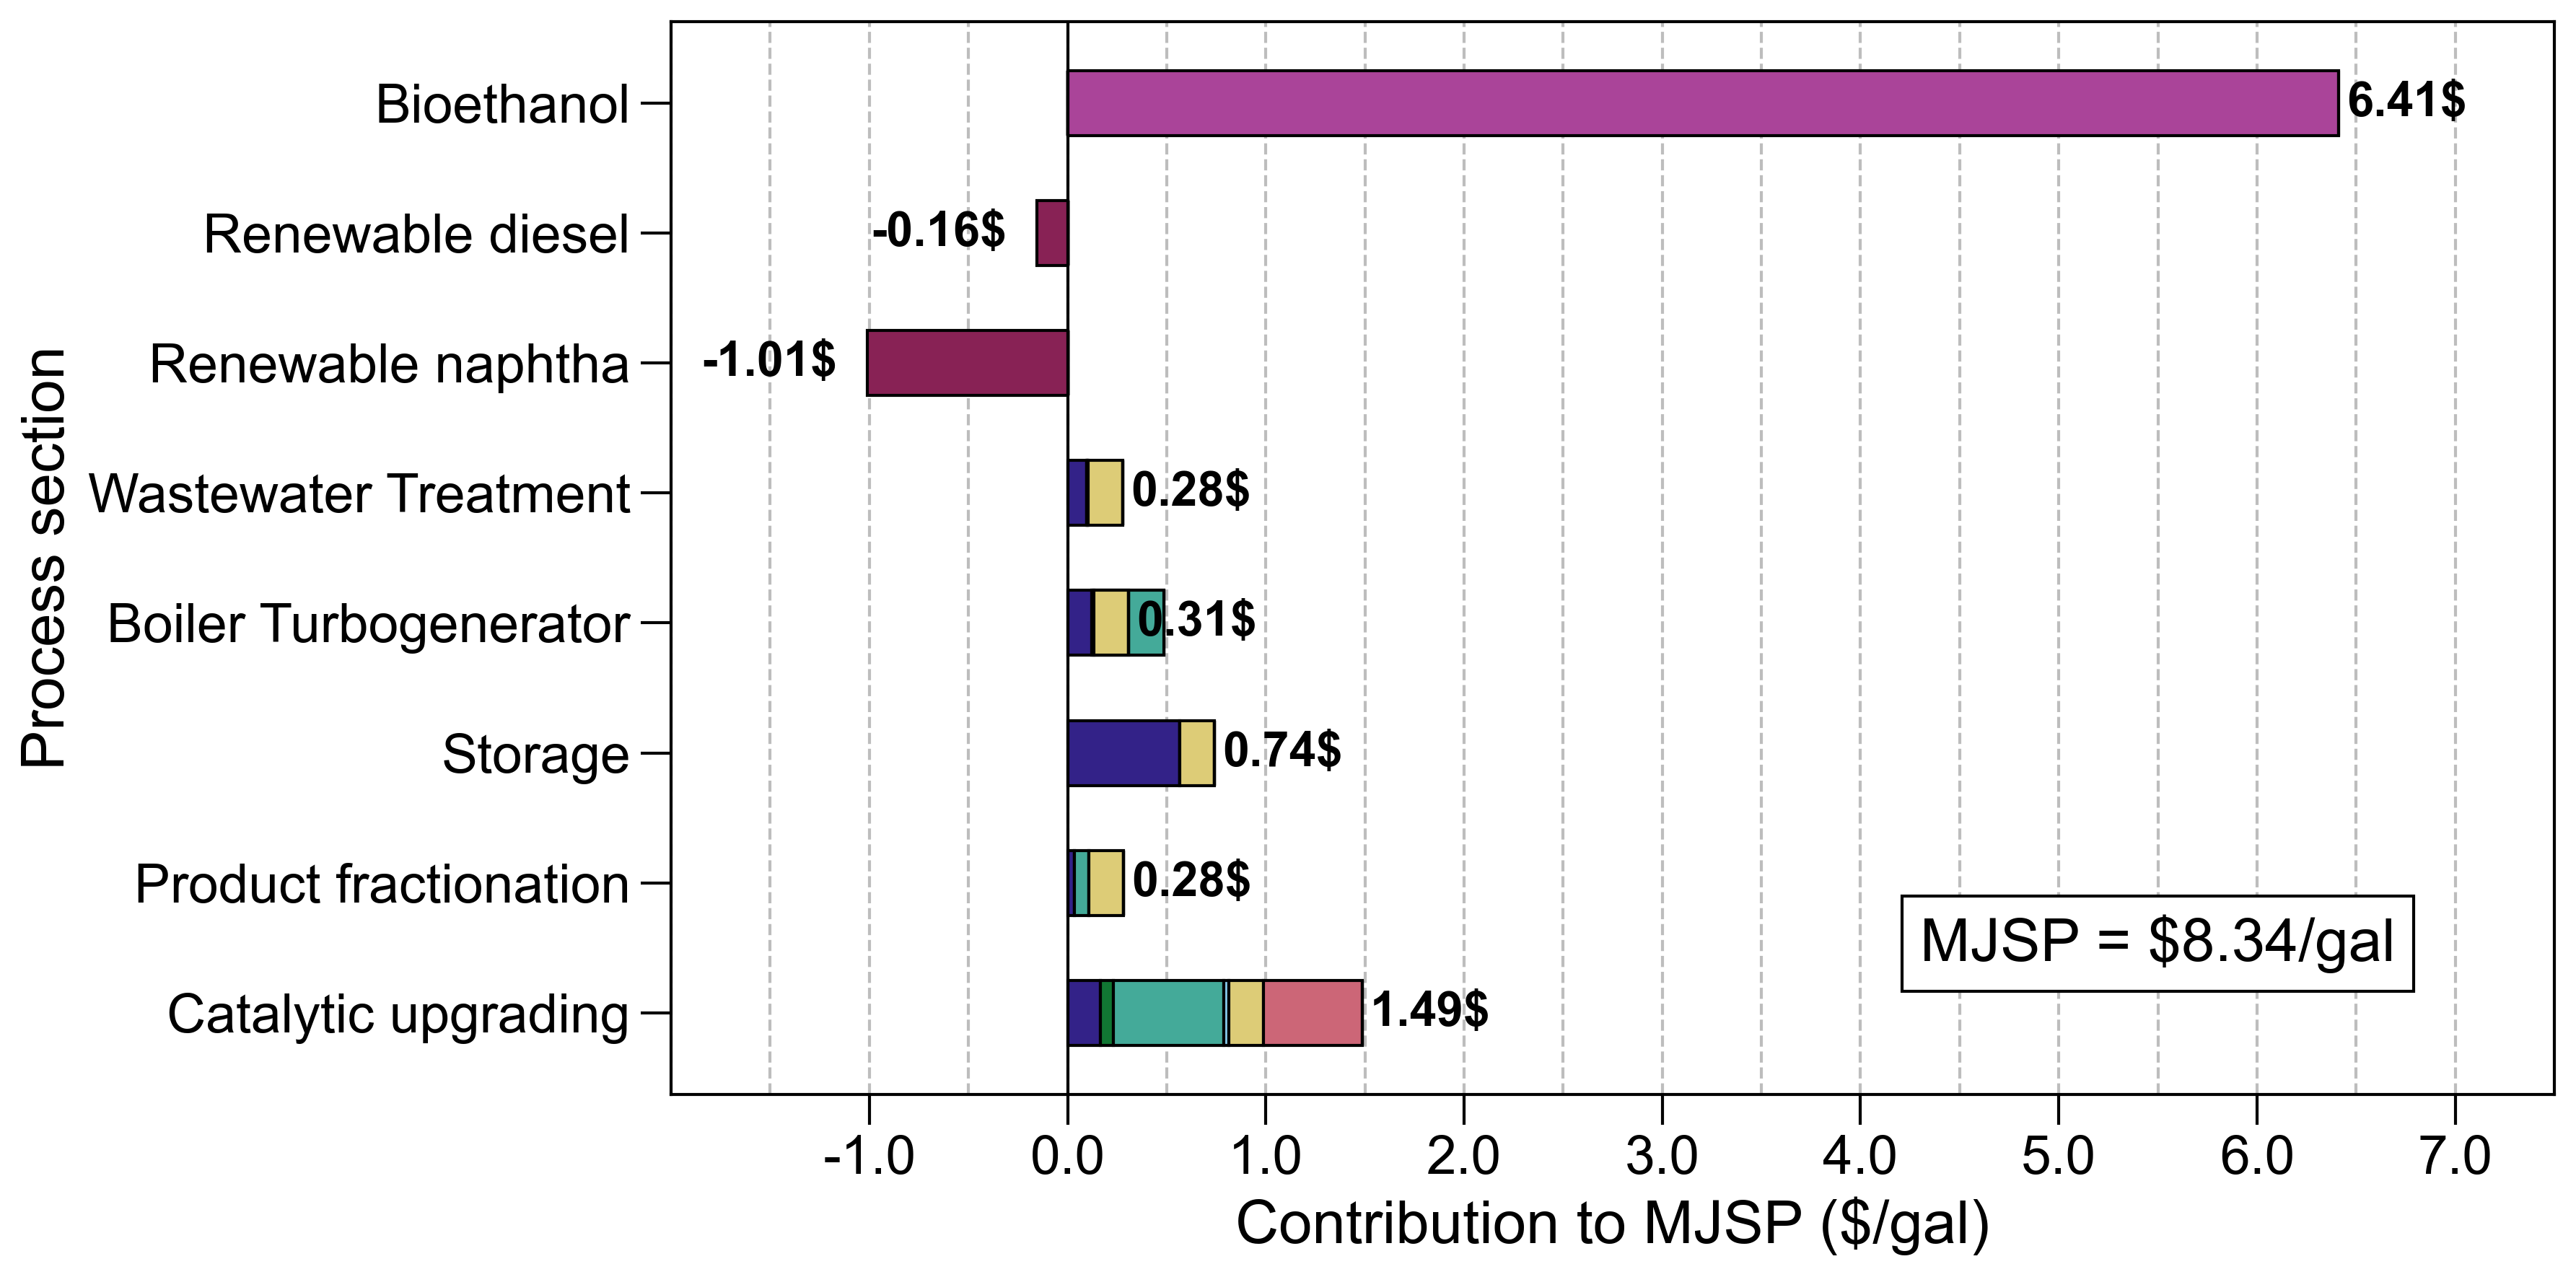

In [93]:
import matplotlib.pyplot as plt
plt.rc('font',family='Arial')


fig, ax = plt.subplots(figsize=(12, 6))

# Colors (optional, set as you wish or let matplotlib choose)
custom_colors = [
    '#332288',  # Installed costs (blue)
    '#117733',  # Catalyst replacement (green)
    '#44AA99',  # Utilities excl. electricity (orange)
    '#88CCEE',  # Process electricity (purple)
    '#DDCC77',  # Fixed costs (red)
    '#CC6677',  # Hydrogen (yellow)
    '#AA4499',  # Ethanol (brown)
    '#882255',  # Co-product (pink)
]

bottom = np.zeros(len(bar_categories))
for i, (cost, label) in enumerate(zip(costs, legend_categories)):
    ax.barh(
        bar_categories, cost, left=bottom, label=label, color=custom_colors[i],
        edgecolor='black', linewidth=1, height = 0.5  # Add borders!
    )
    bottom += cost


# Add labels and legend
ax.set_xlabel('Contribution to MJSP ($/gal)', fontsize = 20)
ax.set_ylabel('Process section', fontsize = 20)
#ax.legend(title="Cost Category", bbox_to_anchor=(1.05, 1), loc='upper left')


ax.tick_params(axis='both', which='major', labelsize=18, width=1, length=10)
# set the axis line width in pixels
for axis in 'left', 'bottom', 'top', 'right':
  ax.spines[axis].set_linewidth(1)

# Add a vertical line at x=0
ax.axvline(0, color='black', linewidth=1)

# Set the x positions for the vertical lines (for example, every 0.2 units from -1 to 1)
xlines = np.arange(-2, 7.5, 0.5)  # adjust range and step as needed

for x in xlines:
    ax.axvline(x, color='#bdbdbd', linestyle='--', linewidth=1, zorder=0)


# Define the range for x-axis ticks
min_tick = -1.0
max_tick = np.ceil(np.max(bottom))  # Or set to your desired max
step = 1.0

# Create ticks at -1.0, 0.0, 1.0, ...
xticks = np.arange(min_tick, max_tick + step, step)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{x:.1f}" for x in xticks], fontsize=18)
ax.set_xlim(-2, 7.5)


bar_totals = np.sum(costs, axis=0)
for i, (category, total) in enumerate(zip(bar_categories, bar_totals)):
    xpos = total + 0.04 if total >= 0 else total - 0.15
    ax.text(
        xpos, i,
        f"{total:.2f}$",
        va='center',
        ha='left' if total >= 0 else 'right',
        fontsize=16,
        fontweight='bold'
    )


ax.text(
    4.3, 0.4,  # x, y position; adjust as needed
    f"MJSP = ${mjsp:.2f}/gal",
    fontsize=20,
    color='black',
    bbox=dict(
        facecolor='white',
        edgecolor='black',
        linewidth=1,         # Thicker box border
        boxstyle='square,pad=0.3'  # Sharp edges
    )
)

plt.tight_layout() 
# plt.savefig('cost_breakdown3.svg', bbox_inches = 'tight')
plt.show()

In [38]:
    F.BT.utility_cost?

Type:        property
String form: <property object at 0x000001D1ED239990>
Docstring:   Total utility cost [USD/hr].

In [33]:
sum(u.power_utility.consumption for u in storage)*price_data['electricity']*final_tea.operating_hours


0.0